# LightGBM Predict Contrib for Multi-Class Classification

## Class `ShapExplain`

```python

import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import os

class ShapExplain:
    def __init__(self, model):
        if hasattr(model, 'classes_') and hasattr(model, 'feature_name_'):
            self.model = model
            self.raw_scores = None
            self.proba_scores = None
            self.labels = None
            self.shap_values = None
            self.shap_contributions = None

            # Initialize class attributes from the model
            self.num_classes = len(model.classes_)
            self.num_features = len(model.feature_name_)
            self.feature_names = model.feature_name_ + ["Bias"]
        else:
            raise ValueError("The provided model does not have the required attributes 'classes_' or 'feature_name_'.")

    def predict_raw_scores(self, X):
        if hasattr(self.model, 'predict'):
            self.raw_scores = self.model.predict(X, raw_score=True)
            return self.raw_scores
        else:
            raise AttributeError("The model does not support raw score predictions.")

    def predict_proba(self, X):
        if hasattr(self.model, 'predict_proba'):
            self.proba_scores = self.model.predict_proba(X)
            return self.proba_scores
        else:
            raise AttributeError("The model does not support probability predictions.")

    def predict_labels(self, X):
        self.predict_proba(X)  # Ensure probabilities are always calculated
        self.labels = [np.argmax(score) for score in self.proba_scores]
        return self.labels

    def calculate_shap_values(self, X):
        if hasattr(self.model, 'predict'):
            self.shap_values = self.model.predict(X, pred_contrib=True)
            return self.shap_values
        else:
            raise AttributeError("The model does not support SHAP value predictions.")

    def split_shap_values(self):
        if self.shap_values is None:
            raise ValueError("SHAP values have not been calculated. Call calculate_shap_values first.")
        
        shap_contributions = {}
        for class_idx in range(self.num_classes):
            start_idx = class_idx * (self.num_features + 1)
            end_idx = start_idx + (self.num_features + 1)
            shap_contributions[f"Class_{class_idx}"] = pd.DataFrame(
                self.shap_values[:, start_idx:end_idx], columns=self.feature_names
            )
        self.shap_contributions = shap_contributions
        return self.shap_contributions
    
    def calculate_mean_absolute_shap_contributions(self):
        """
        Calculate the mean absolute SHAP contributions for each feature and class.

        Returns:
            pd.DataFrame: A DataFrame where rows represent features, columns represent classes,
                        and values are the mean absolute SHAP contributions.
        """
        if self.shap_contributions is None:
            raise ValueError("SHAP contributions have not been split. Call split_shap_values first.")
        
        mean_abs_contributions = {}
        for class_name, shap_values_df in self.shap_contributions.items():
            # Exclude the "Bias" column and calculate the mean absolute value
            mean_abs_contributions[class_name] = shap_values_df.iloc[:, :-1].abs().mean(axis=0)
        
        # Combine into a DataFrame for easier interpretation
        mean_abs_df = pd.DataFrame(mean_abs_contributions)
        mean_abs_df.index.name = "Feature"
        
        return mean_abs_df

    def plot_shap_summary(self, plot_type='bar', output_dir=None, title_prefix=None):
        
        # Ensure output directory exists if specified
        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir)

        for class_name, shap_values_df in self.shap_contributions.items():
            shap_values = shap_values_df.iloc[:, :-1].values
            feature_names = shap_values_df.columns[:-1]  # Exclude 'Bias' from feature names

            plt.figure()
            shap.summary_plot(shap_values, feature_names=feature_names, plot_type=plot_type, show=False)

            title = f'SHAP Summary Plot for {class_name}'
            if title_prefix:
                title = f'{title_prefix} {title}'
            plt.title(title)

            if output_dir:
                filename = f'{title_prefix}_{class_name}_shap_summary.png' if title_prefix else f'{class_name}_shap_summary.png'
                plt.savefig(os.path.join(output_dir, filename), bbox_inches='tight')
                plt.close()
            else:
                plt.show()

# Example usage:
# Assuming `model` and `X_test` are defined, and the model is already fitted with attributes like classes_ and feature_names_.
# shap_explain = ShapExplain(model)
# raw_scores = shap_explain.predict_raw_scores(X_test)
# proba_scores = shap_explain.predict_proba(X_test)
# labels = shap_explain.predict_labels(X_test)
# shap_values = shap_explain.calculate_shap_values(X_test)
# shap_contributions = shap_explain.split_shap_values()

# # Create a Pandas Excel writer using openpyxl as the engine
# with pd.ExcelWriter('shap_explain_output.xlsx', engine='openpyxl') as writer:
#     # Convert raw_scores and labels to DataFrames and write to Excel
#     pd.DataFrame(raw_scores).to_excel(writer, sheet_name='Raw Scores')
#     pd.DataFrame(proba_scores, columns=[f"Class_{i}" for i in range(shap_explain.num_classes)]).to_excel(writer, sheet_name='Probabilities')
#     pd.DataFrame(labels, columns=['Predicted Labels']).to_excel(writer, sheet_name='Labels')

#     # Write each class's SHAP contributions to a separate sheet
#     for class_name, df in shap_contributions.items():
#         df.to_excel(writer, sheet_name=f'SHAP Values {class_name}')
```

Class `ShapExplain` được thiết kế để hỗ trợ việc giải thích các mô hình Machine Learning sử dụng SHAP (SHapley Additive exPlanations). Class này giúp người dùng:
1. **Tính toán các giá trị SHAP** cho mô hình.
2. **Tách riêng các đóng góp SHAP theo lớp (class)**.
3. **Tạo các biểu đồ SHAP** để minh họa ảnh hưởng của từng đặc trưng đến dự đoán của mô hình.

Class yêu cầu mô hình đầu vào phải có hai thuộc tính quan trọng:
- `classes_`: Danh sách các lớp trong bài toán phân loại.
- `feature_name_`: Danh sách các đặc trưng được sử dụng trong mô hình.

### Các phương thức chính

1. **`__init__`**: 
   - Khởi tạo class với mô hình và kiểm tra mô hình có các thuộc tính cần thiết (`classes_`, `feature_name_`).
   - Gán các giá trị ban đầu (số lượng lớp, số lượng đặc trưng, v.v.).

2. **`predict_raw_scores`**:
   - Dự đoán điểm số "thô" (raw scores) từ mô hình.

3. **`predict_proba`**:
   - Dự đoán xác suất của từng lớp.

4. **`predict_labels`**:
   - Dự đoán nhãn (label) bằng cách chọn lớp có xác suất cao nhất.

5. **`calculate_shap_values`**:
   - Tính giá trị SHAP bằng cách sử dụng phương pháp `predict` với `pred_contrib=True`.

6. **`split_shap_values`**:
   - Phân tách giá trị SHAP theo từng lớp (class) thành các DataFrame riêng biệt.

7. **`calculate_mean_absolute_shap_contributions`**:
   - Tính giá trị trung bình tuyệt đối của các đóng góp SHAP (mean absolute SHAP contributions) để hiểu đặc trưng nào quan trọng nhất.

8. **`plot_shap_summary`**:
   - Tạo biểu đồ SHAP (summary plot) cho từng lớp, lưu vào thư mục hoặc hiển thị trực tiếp.

---


In [3]:

import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import os

class ShapExplain:
    def __init__(self, model):
        if hasattr(model, 'classes_') and hasattr(model, 'feature_name_'):
            self.model = model
            self.raw_scores = None
            self.proba_scores = None
            self.labels = None
            self.shap_values = None
            self.shap_contributions = None

            # Initialize class attributes from the model
            self.num_classes = len(model.classes_)
            self.num_features = len(model.feature_name_)
            self.feature_names = model.feature_name_ + ["Bias"]
        else:
            raise ValueError("The provided model does not have the required attributes 'classes_' or 'feature_name_'.")

    def predict_raw_scores(self, X):
        if hasattr(self.model, 'predict'):
            self.raw_scores = self.model.predict(X, raw_score=True)
            return self.raw_scores
        else:
            raise AttributeError("The model does not support raw score predictions.")

    def predict_proba(self, X):
        if hasattr(self.model, 'predict_proba'):
            self.proba_scores = self.model.predict_proba(X)
            return self.proba_scores
        else:
            raise AttributeError("The model does not support probability predictions.")

    def predict_labels(self, X):
        self.predict_proba(X)  # Ensure probabilities are always calculated
        self.labels = [np.argmax(score) for score in self.proba_scores]
        return self.labels

    def calculate_shap_values(self, X):
        if hasattr(self.model, 'predict'):
            self.shap_values = self.model.predict(X, pred_contrib=True)
            return self.shap_values
        else:
            raise AttributeError("The model does not support SHAP value predictions.")

    def split_shap_values(self):
        if self.shap_values is None:
            raise ValueError("SHAP values have not been calculated. Call calculate_shap_values first.")
        
        shap_contributions = {}
        for class_idx in range(self.num_classes):
            start_idx = class_idx * (self.num_features + 1)
            end_idx = start_idx + (self.num_features + 1)
            shap_contributions[f"Class_{class_idx}"] = pd.DataFrame(
                self.shap_values[:, start_idx:end_idx], columns=self.feature_names
            )
        self.shap_contributions = shap_contributions
        return self.shap_contributions
    
    def calculate_mean_absolute_shap_contributions(self):
        """
        Calculate the mean absolute SHAP contributions for each feature and class.

        Returns:
            pd.DataFrame: A DataFrame where rows represent features, columns represent classes,
                        and values are the mean absolute SHAP contributions.
        """
        if self.shap_contributions is None:
            raise ValueError("SHAP contributions have not been split. Call split_shap_values first.")
        
        mean_abs_contributions = {}
        for class_name, shap_values_df in self.shap_contributions.items():
            # Exclude the "Bias" column and calculate the mean absolute value
            mean_abs_contributions[class_name] = shap_values_df.iloc[:, :-1].abs().mean(axis=0)
        
        # Combine into a DataFrame for easier interpretation
        mean_abs_df = pd.DataFrame(mean_abs_contributions)
        mean_abs_df.index.name = "Feature"
        
        return mean_abs_df

    def plot_shap_summary(self, plot_type='bar', output_dir=None, title_prefix=None):
        
        # Ensure output directory exists if specified
        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir)

        for class_name, shap_values_df in self.shap_contributions.items():
            shap_values = shap_values_df.iloc[:, :-1].values
            feature_names = shap_values_df.columns[:-1]  # Exclude 'Bias' from feature names

            plt.figure()
            shap.summary_plot(shap_values, feature_names=feature_names, plot_type=plot_type, show=False)

            title = f'SHAP Summary Plot for {class_name}'
            if title_prefix:
                title = f'{title_prefix} {title}'
            plt.title(title)

            if output_dir:
                filename = f'{title_prefix}_{class_name}_shap_summary.png' if title_prefix else f'{class_name}_shap_summary.png'
                plt.savefig(os.path.join(output_dir, filename), bbox_inches='tight')
                plt.close()
            else:
                plt.show()

In [1]:
# LightGBM Predict Contrib for Multi-Class Classification

# Import necessary libraries
import numpy as np
import pandas as pd
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Step 1: Load Dataset
wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = wine.target

# Step 2: Split Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Train LightGBM Model
model = lgb.LGBMClassifier(verbosity = -1)
model.fit(X_train, y_train)



LGBMClassifier(verbosity=-1)

In [6]:
# Example usage:
shap_explain = ShapExplain(model)
raw_scores = shap_explain.predict_raw_scores(X_test)
proba_scores = shap_explain.predict_proba(X_test)
labels = shap_explain.predict_labels(X_test)
shap_values = shap_explain.calculate_shap_values(X_test)
shap_contributions = shap_explain.split_shap_values()
mean_abs_contributions = shap_explain.calculate_mean_absolute_shap_contributions()

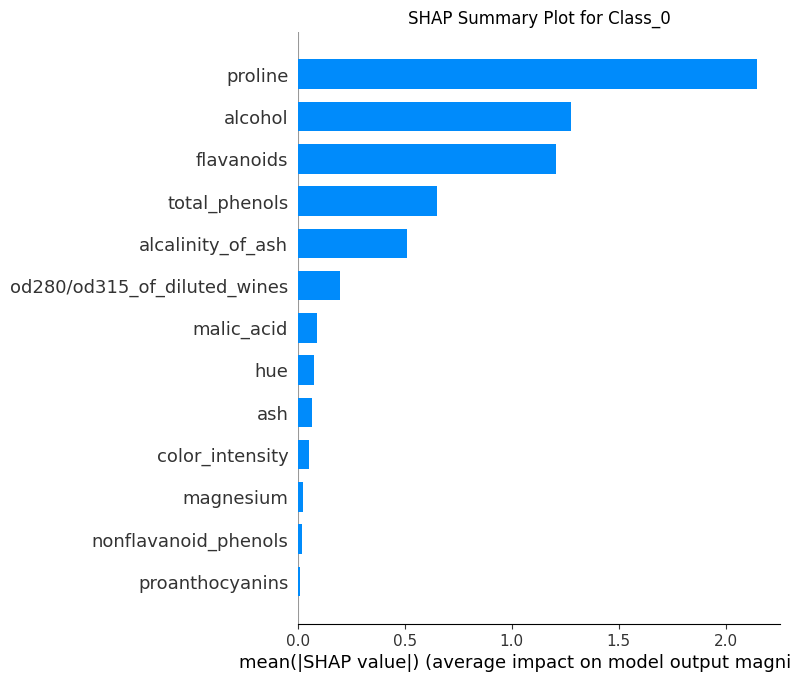

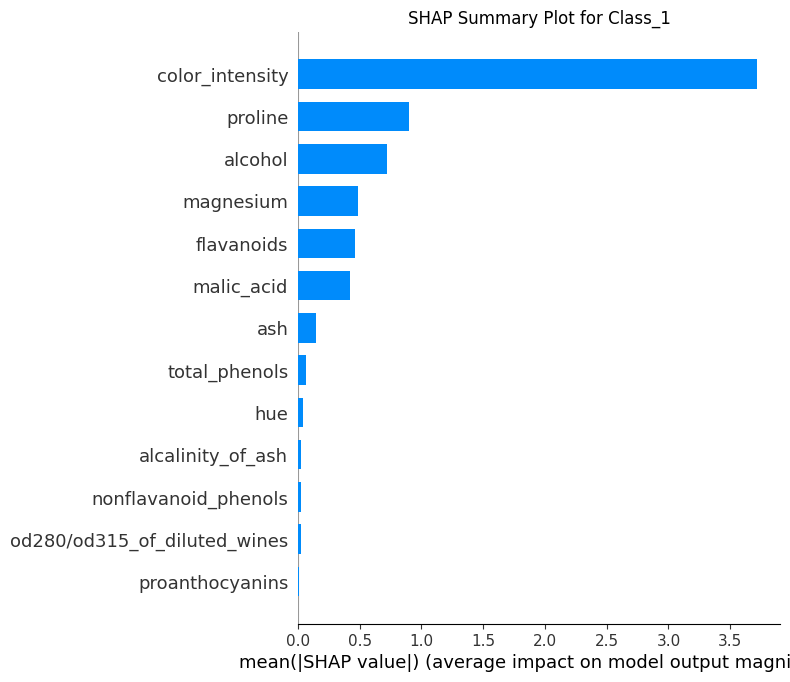

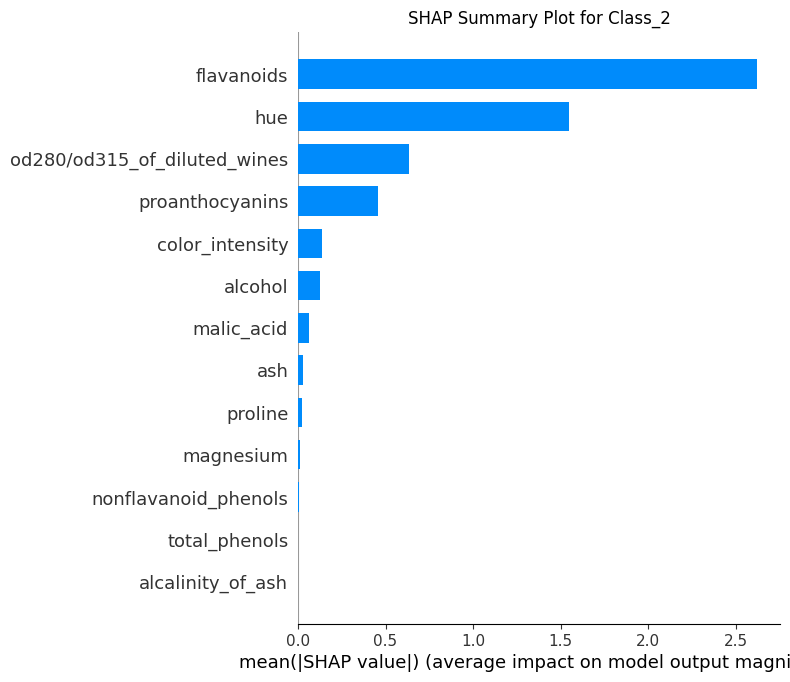

In [7]:
shap_explain.plot_shap_summary()